<a href="https://colab.research.google.com/github/eminshall/FreeCodeCamp-Projects-TensorFlow/blob/main/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#I relied heavily on YouTube videos and other notebooks I found in Github to code this project.
#I did my best to make the code my own, apologies in advance if it wasn't enough.
#I'd include contributors, but there were dozens.

# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.9/566.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.0 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.1.4 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.12.0-dev20230116


In [2]:
#Import more libraries
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

In [3]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-01-17 09:54:06--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.006s  

2023-01-17 09:54:06 (56.2 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-01-17 09:54:06--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==========

In [4]:
#Make Data Frames
df_train = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])

df_test = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])

In [5]:
df_train.isna().sum()

type    0
msg     0
dtype: int64

In [6]:
df_test.isna().sum()

type    0
msg     0
dtype: int64

In [7]:
df_train.head(3)

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...


In [8]:
df_test.head(3)

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...


In [9]:
#Prepare Labels
df_train["type"] = pd.factorize(df_train["type"])[0]
df_test["type"] = pd.factorize(df_test["type"])[0]

In [10]:
df_train.head()

,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [11]:
train_labels =  df_train["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (df_train["msg"].values, train_labels)
)

In [12]:
test_labels = df_test["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (df_test["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [13]:
#Set Batching
buffer = 100
batch_size = 32
train_ds = train_ds.shuffle(buffer).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
# Text vectorization
textvector = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

textvector.adapt(train_ds.map(lambda text, label: text))

In [15]:
#Prepare data
# Text vectorization: Vocabulary learnt by our vectorizer
vocab = np.array(textvector.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

In [16]:
# Create the model
model = tf.keras.Sequential([
    textvector,
    tf.keras.layers.Embedding(
        len(textvector.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [17]:
# Train the model against data sets
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 153s 3s/step - loss: 0.6796 - accuracy: 0.8657 - val_loss: 0.6594 - val_accuracy: 0.8604
Epoch 2/10
44/44 [==============================] - 132s 3s/step - loss: 0.6160 - accuracy: 0.8657 - val_loss: 0.5581 - val_accuracy: 0.8604
Epoch 3/10
44/44 [==============================] - 121s 3s/step - loss: 0.5146 - accuracy: 0.8657 - val_loss: 0.4821 - val_accuracy: 0.8604
Epoch 4/10
44/44 [==============================] - 127s 3s/step - loss: 0.4407 - accuracy: 0.8657 - val_loss: 0.4048 - val_accuracy: 0.8604
Epoch 5/10
44/44 [==============================] - 132s 3s/step - loss: 0.3582 - accuracy: 0.8657 - val_loss: 0.2926 - val_accuracy: 0.8604
Epoch 6/10
44/44 [==============================] - 121s 3s/step - loss: 0.2276 - accuracy: 0.8671 - val_loss: 0.1694 - val_accuracy: 0.8604
Epoch 7/10
44/44 [==============================] - 132s 3s/step - loss: 0.1464 - accuracy: 0.9181 - val_loss: 0.1182 - val_accuracy: 0.9729
Epoch 8/10
44

In [18]:
test_loss, test_acc = model.evaluate(test_ds)

44/44 [==============================] - 21s 475ms/step - loss: 0.0524 - accuracy: 0.9878


In [19]:
# Plot the accuracy and loss metrics
# Create a helper function to plot
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.710748583637178)

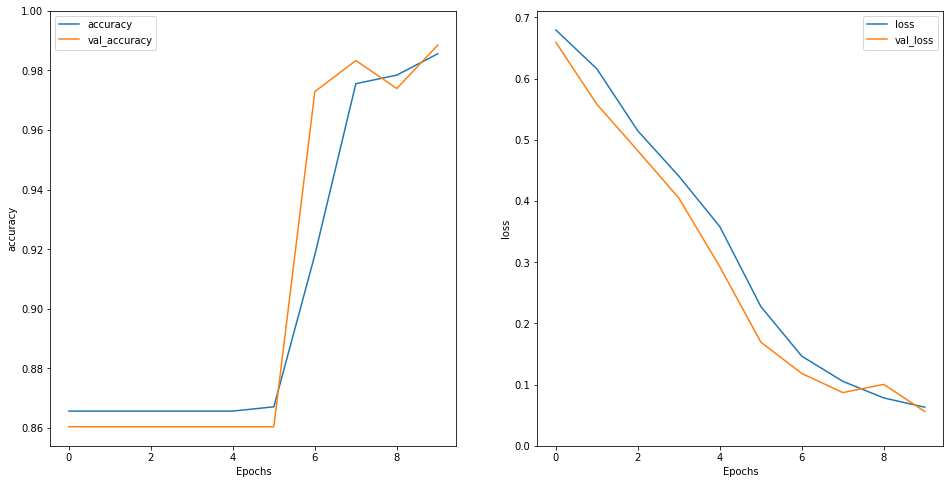

In [20]:
# Plot the accuracy and loss metrics
# Plot the graphs
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None) 

In [21]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

    pred_text = "how are you doing today?"

    prediction = predict_message(pred_text)
    print(prediction)

    return (prediction)

In [23]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 213ms/step
[[-4.0616007]]
1/1 [==============================] - 0s 245ms/step
[[0.22138576]]
1/1 [==============================] - 0s 230ms/step
[[-8.706349]]
1/1 [==============================] - 0s 219ms/step
[[1.7955085]]
1/1 [==============================] - 0s 223ms/step
[[1.8807735]]
1/1 [==============================] - 0s 248ms/step
[[-8.152686]]
1/1 [==============================] - 0s 216ms/step
[[-8.215732]]
You haven't passed yet. Keep trying.
